# Imports

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

Our loss function works as follows

The MLP returns a (t, 1) dimensional array, where T is the number of class labels that are being predicted.
Each value in that array is the probability of a sample belonging to each class label. 

Our true class label, y, is thus represented as a (t, 1) dimensional array which is One Hot Encoded.

So if we have 10 class labels, t = 10.

and our output may look something like

[.1, .9, ..., .3]

and our true y label (assuming the label is meant to be 2) is 

[0, 1, ..., 0]

we would then need to calculate the Mean Squared Error for those two arrays like so

([.1, .9, ..., .3] - [0, 1, ..., 0])^2 => ([.1, -.1, ..., .3])^2 => [.01, .01, ..., .03] 

Finally, to complete the "Mean" Squared Error, we simply find 

mean([.01, .01, ..., .03])

whatever that turns out to be.

our mean can be thought of as sum([.01, .01, ..., .03]) / t, or sum([.01, .01, ..., .03]) / 10 in this case.

We would do this for every sample, where our total number of samples is n.

We would them calculate the mean of all the means summed together like so

sum( all errors for each sample ) / n.

if we have 1000 samples, it would be

sum( all errors for each sample ) / 1000

That is the MSE for the epoch in which the predictions were made.

# Classifying Handwritten Digits with a Neural Network (NN)

### Importing MNIST Image Data

In [7]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto')

X = X.values
y = y.astype(int).values

total_images, pixels_per_image = X.shape
total_class_labels, *_ = y.shape

print(f'Total Images: {total_images}')
print(f'Total Pixels Per Image: {pixels_per_image}')
print(f'Total Class Labels: {total_class_labels}')

''' verify dimensions and total pixels '''
assert total_images == total_class_labels
assert pixels_per_image == 784

Total Images: 70000
Total Pixels Per Image: 784
Total Class Labels: 70000


### Normalizing Pixel Values from 0-255 range to -1-1 (negative one to one)

In [8]:
X = ((X / 255.) - .5) * 2

### Visualizing Digit Examples from MNIST

#### Visualizing 0-9

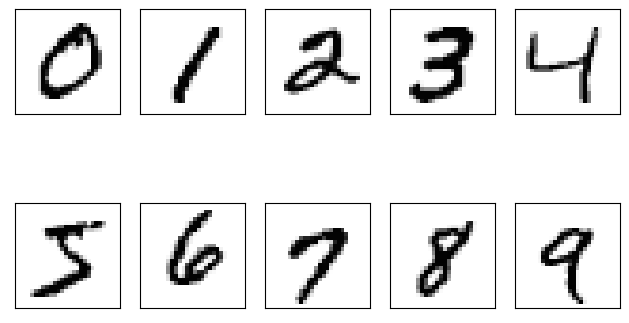

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()

for i in range(10):
    img = X[y == i][0].reshape(28, 28) # each image has 784 pixels, but they're actually 28x28 pixel images
    ax[i].imshow(img, cmap='Greys')
    
ax[0].set_xticks([])
ax[0].set_yticks([])

plt.tight_layout()
plt.show()

#### Visualizing all examples for 7

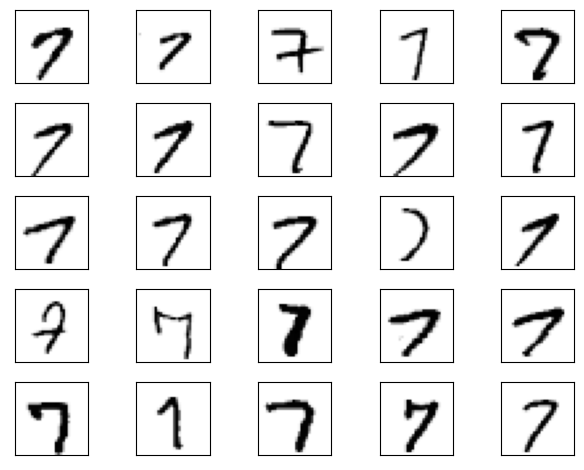

In [13]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()

for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
    
ax[0].set_xticks([])
ax[0].set_yticks([])

plt.tight_layout()
plt.show()

### Split the dataset into training, validation, and test subsets

In [17]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=10000, random_state=123, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)

### Implementing a Multi-layer Perceptron (MLP)

In [35]:
def sigmoid(z: np.ndarray) -> np.ndarray:
    """
    Compute the sigmoid activation function.

    Parameters:
    - z (np.ndarray): Input array.

    Returns:
    - np.ndarray: Result of the sigmoid function applied to each element of z.
    """
    return 1. / (1. + np.exp(-z))

def int_to_onehot(y: np.ndarray, num_labels: int) -> np.ndarray:
    """
    Convert integer labels to one-hot encoded vectors.

    Parameters:
    - y (np.ndarray): Array of integer labels.
    - num_labels (int): Total number of classes.

    Returns:
    - np.ndarray: One-hot encoded array.
    """
    arr = np.zeros((y.shape[0], num_labels))
    
    for i, val in enumerate(y):
        arr[i, val] = 1
    
    return arr

class NeuralNetMLP:
    ''' A simple implementation of a Multi-Layer Perceptron (MLP) neural network. '''
    
    def __init__(
        self, 
        num_features: int, 
        num_hidden: int, 
        num_classes: int, 
        random_seed: int = 123
    ) -> None:
        '''
        Initialize a Multi-Layer Perceptron (MLP) neural network.

        Parameters:
        - num_features (int): Total features for each sample.
        - num_hidden   (int): Total hidden layers in the model.
        - num_classes  (int): Total classes (y labels) to be predicted.
        - random_seed  (int): Seed used to create an np.random.RandomState.
        '''
        self.num_classes = num_classes
        rng = np.random.RandomState(seed=random_seed)
        
        # Initialize random weights for the hidden layer
        self.weight_hidden = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features)
        )
        
        # Initialize biases for each hidden layer
        self.bias_hidden = np.zeros(num_hidden)
        
        # Initialize random weights for the output layer
        self.weight_output = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden)
        )
        
        # Initialize biases for the output layer
        self.bias_output = np.zeros(num_classes)

    def forward(self, X: np.ndarray) -> tuple[np.ndarray]:
        '''
        Perform forward pass through the network.

        Parameters:
        - X (np.ndarray): Input data.

        Returns:
        - tuple[np.ndarray]: Activations of hidden and output layers.
        '''
        # Compute activations for the hidden layer
        z_hidden = np.dot(X, self.weight_hidden.T) + self.bias_hidden
        a_hidden = sigmoid(z_hidden)
        
        # Compute activations for the output layer
        z_output = np.dot(a_hidden, self.weight_output.T) + self.bias_output
        a_output = sigmoid(z_output)
        
        return a_hidden, a_output
    
    def backward(
        self, 
        X: np.ndarray, 
        a_h: np.ndarray, 
        a_out: np.ndarray, 
        y: np.ndarray
    ) -> tuple[np.ndarray]:
        '''
        Perform backward pass through the network.

        Parameters:
        - X (np.ndarray): Input data.
        - a_h (np.ndarray): Activations of hidden layer.
        - a_out (np.ndarray): Activations of output layer.
        - y (np.ndarray): True labels.

        Returns:
        - tuple[np.ndarray]: Gradients with respect to weights and biases.
        '''
        y_onehot = int_to_onehot(y, self.num_classes)
        
        # Compute gradients for output layer
        loss_grad_output = 2. * (a_out - y_onehot) / y.shape[0]
        sigmoid_derivative_output = a_out * (1. - a_out)
        delta_output = loss_grad_output * sigmoid_derivative_output
        
        # Gradients with respect to output layer weights and biases
        grad_w_out = np.dot(delta_output.T, a_h)
        grad_b_out = np.sum(delta_output, axis=0)
        
        # Compute gradients for hidden layer
        grad_a_h = np.dot(delta_output, self.weight_output)
        sigmoid_derivative_hidden = a_h * (1. - a_h)
        delta_hidden = grad_a_h * sigmoid_derivative_hidden
        
        # Gradients with respect to hidden layer weights and biases
        grad_w_h = np.dot(delta_hidden.T, X)
        grad_b_h = np.sum(delta_hidden, axis=0)
        
        return (grad_w_out, grad_b_out, grad_w_h, grad_b_h)

### Constructing the NN training loop

In [36]:
def minibatch_generator(X : np.ndarray, y : np.ndarray, minibatch_size : int):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    
    for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
        batch_idx = indices[start_idx : start_idx + minibatch_size]
        yield X[batch_idx], y[batch_idx]

def mse_loss(targets : np.ndarray, probas : np.ndarray, num_labels : int = 10):
    onehot_targets = int_to_onehot(targets, num_labels)
    return np.mean((onehot_targets - probas)**2)

def accuracy(targets : np.ndarray, predicted_labels : np.ndarray):
    return np.mean(predicted_labels == targets)

def compute_mse_and_accuracy(
    nnet : NeuralNetMLP, 
    X : np.ndarray, 
    y : np.ndarray, 
    num_labels : int = 10, 
    minibatch_size : int = 100
) -> tuple[float, float] :
    
    mse, correct_pred, num_examples = 0., 0, 0
    
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
    
    for i, (features, targets) in enumerate(minibatch_gen):
        
        _, probas = nnet.forward(features)
        
        predicted_labels = np.argmax(probas, axis=1)
        
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        
        loss = np.mean((onehot_targets - probas) ** 2)
        correct_pred += (predicted_labels == targets).sum()
        num_examples += targets.shape[0]
        mse += loss
        
    mse /= i
    
    acc = correct_pred / num_examples
    
    return mse, acc

def train(
    model          : NeuralNetMLP, 
    X_train        : np.ndarray, 
    y_train        : np.ndarray, 
    X_valid        : np.ndarray, 
    y_valid        : np.ndarray, 
    num_epochs     : int, 
    learning_rate  : float = .1,
    minibatch_size : int = 100
):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    
    for e in range(num_epochs):
        
        minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
        
        for X_train_mini, y_train_mini in minibatch_gen:
            
            a_h, a_out = model.forward(X_train_mini)
            
            _back = model.backward(
                X_train_mini, 
                a_h, 
                a_out, 
                y_train_mini
            )
            
            # d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h
            grad_w_out, grad_b_out, grad_w_h, grad_b_h = _back
            
            model.weight_hidden -= learning_rate * grad_w_h
            model.bias_hidden   -= learning_rate * grad_b_h
            model.weight_output -= learning_rate * grad_w_out
            model.bias_output   -= learning_rate * grad_b_out
            
        train_mse, train_acc = compute_mse_and_accuracy(
            model, X_train, y_train
        )
        
        valid_mse, valid_acc = compute_mse_and_accuracy(
            model, X_valid, y_valid
        )
        
        train_acc, valid_acc = train_acc * 100, valid_acc * 100
        
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f' | Train MSE: {train_mse : .2f}'
              f' | Train Acc: {train_acc : .2f}'
              f' | Valid Acc: {valid_acc : .2f}'
        )
        
    return epoch_loss, epoch_train_acc, epoch_valid_acc
            
            
np.random.seed(123)

num_epochs = 50
minibatch_size = 100

model = NeuralNetMLP(num_features=28*28, num_hidden=50, num_classes=10)

epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, 
    X_train, 
    y_train, 
    X_valid, 
    y_valid, 
    num_epochs=num_epochs, 
    learning_rate=.1,
    minibatch_size=minibatch_size
)      

Epoch: 001/050  | Train MSE:  0.05 | Train Acc:  76.15 | Valid Acc:  75.98
Epoch: 002/050  | Train MSE:  0.03 | Train Acc:  85.45 | Valid Acc:  85.04
Epoch: 003/050  | Train MSE:  0.02 | Train Acc:  87.82 | Valid Acc:  87.60
Epoch: 004/050  | Train MSE:  0.02 | Train Acc:  89.36 | Valid Acc:  89.28
Epoch: 005/050  | Train MSE:  0.02 | Train Acc:  90.21 | Valid Acc:  90.04
Epoch: 006/050  | Train MSE:  0.02 | Train Acc:  90.67 | Valid Acc:  90.54
Epoch: 007/050  | Train MSE:  0.02 | Train Acc:  91.12 | Valid Acc:  90.82
Epoch: 008/050  | Train MSE:  0.02 | Train Acc:  91.43 | Valid Acc:  91.26
Epoch: 009/050  | Train MSE:  0.01 | Train Acc:  91.84 | Valid Acc:  91.50
Epoch: 010/050  | Train MSE:  0.01 | Train Acc:  92.04 | Valid Acc:  91.84
Epoch: 011/050  | Train MSE:  0.01 | Train Acc:  92.30 | Valid Acc:  92.08
Epoch: 012/050  | Train MSE:  0.01 | Train Acc:  92.51 | Valid Acc:  92.24
Epoch: 013/050  | Train MSE:  0.01 | Train Acc:  92.65 | Valid Acc:  92.30
Epoch: 014/050  | Train M

### Evaluating Model Performance

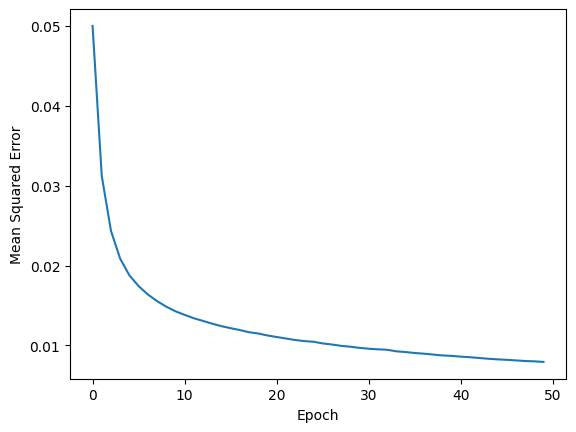

In [37]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()

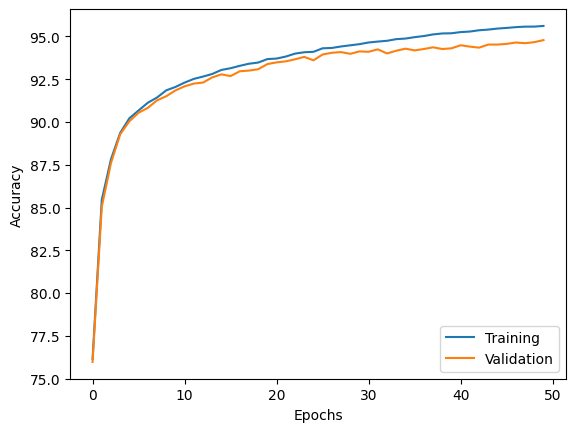

In [38]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc, label = 'Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc, label = 'Validation')
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(loc='lower right')
plt.show()

In [39]:
''' Calculating Generalization Performance '''
test_mse, test_acc = compute_mse_and_accuracy(
    model, X_test, y_test
)

print(f'Test Accuracy: {test_acc*100 : .2f}%')

Test Accuracy:  94.54%


#### Images our model struggled with

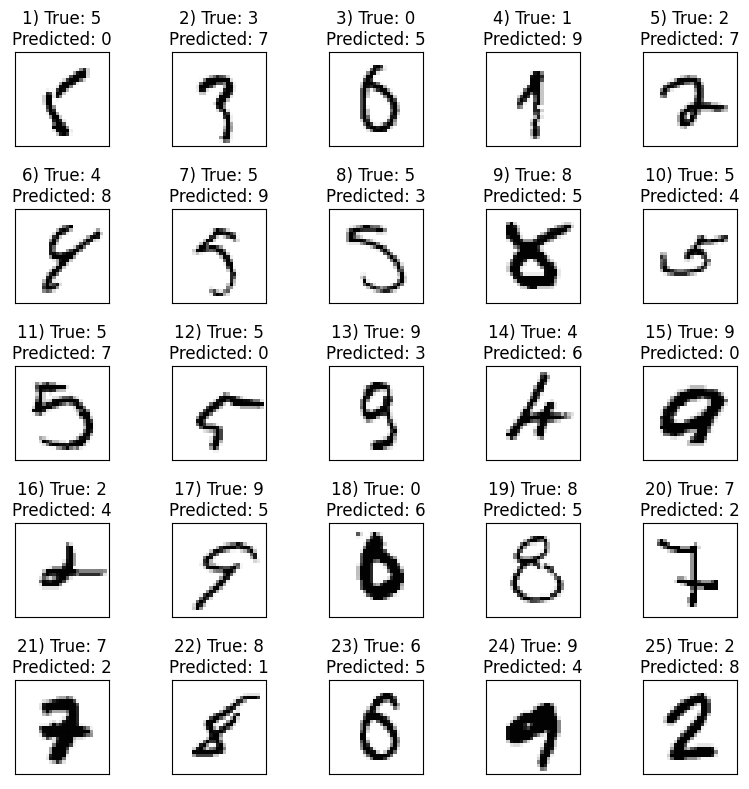

In [40]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels       = y_test_subset[y_test_subset != test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(8,8))
ax = ax.flatten()

for i in range(25):
    
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f'Predicted: {misclassified_labels[i]}'

    )
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()